In [1]:
%load_ext jupyter_black

In [7]:
from glob import glob
from abc import ABC, abstractmethod
from typing import Callable, Literal, overload
import functools

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

In [8]:
LEVEL_TYPES = [
    {"typeOfLevel": "hybrid"},
    {"typeOfLevel": "depthBelowLandLayer"},
    {"typeOfLevel": "atmosphere"},
    {"typeOfLevel": "cloudTop"},
    {"typeOfLevel": "surface"},
    {"typeOfLevel": "heightAboveGround"},
    {"typeOfLevel": "isothermal"},
    {"typeOfLevel": "pressureFromGroundLayer"},
    {"typeOfLevel": "sigmaLayer"},
    {"typeOfLevel": "meanSea"},
    {"typeOfLevel": "isobaricInhPa"},
    {"typeOfLevel": "heightAboveGroundLayer"},
    {"typeOfLevel": "sigma"},
    {"typeOfLevel": "atmosphereSingleLayer", "stepType": "max"},
    {"typeOfLevel": "atmosphereSingleLayer", "stepType": "instant"},
    {"typeOfLevel": "depthBelowLand"},
    {"typeOfLevel": "isobaricLayer"},
    {"typeOfLevel": "lowCloudLayer"},
    {"typeOfLevel": "middleCloudLayer"},
    {"typeOfLevel": "highCloudLayer"},
    {"typeOfLevel": "cloudCeiling"},
    {"typeOfLevel": "cloudBase"},
    {"typeOfLevel": "nominalTop"},
    {"typeOfLevel": "isothermZero"},
    {"typeOfLevel": "highestTroposphericFreezing"},
    {"typeOfLevel": "adiabaticCondensation"},
    {"typeOfLevel": "equilibrium"},
    {"typeOfLevel": "unknown"},
]

In [56]:
class DocStrings(ABC):
    @abstractmethod
    def isothermal(self):
        """
        ### coordinates:
            units : degrees_north
            standard_name :latitude

            units : degrees_east
            standard_name : longitude
            valid_time : datetime64[ns, utc]
            standard_name : valid_time

        ### Data variables:
            GRIB_name : Derived radar reflectivity
            GRIB_shortName : refd
            GRIB_units : dB


        ##
        filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isothermal'}
        filter_by_keys={'stepType': 'max', 'typeOfLevel': 'isothermal'}
        """

    @abstractmethod
    def atmosphere(self):
        """
        ### coordinates:
            units : degrees_north
            standard_name :latitude

            units : degrees_east
            standard_name : longitude

            valid_time : datetime64[ns, utc]
            standard_name : valid_time

        ### Data variables:

        name : Maximum/Composite radar reflectivity
        shortName : refc
        units : dB

        name : Vertically-integrated liquid
        shortName : veril
        units : kg m**-1

        GRIB_name : Hail
        GRIB_shortName : hail
        GRIB_units : m

        GRIB_name : Total Cloud Cover
        GRIB_shortName : tcc
        GRIB_units : %
        """

    @abstractmethod
    def hybrid(self):
        """
        ### coordinates:
            units : degrees_north
            standard_name :latitude

            units : degrees_east
            standard_name : longitude

            valid_time : datetime64[ns, utc]
            standard_name : valid_time

        Data variables:
            name : Pressure
            units : Pa
            shortName : pres

            name : Cloud mixing ratio
            units : kg kg**-1
            shortName : clwmr

            name : unknown
            units : unknown
            shortName : unknown

            name : Rain mixing ratio
            units : kg kg**-1
            shortName : rwmr

            name : Snow mixing ratio
            units : kg kg**-1
            shortName : snmr

            name : Graupel (snow pellets)
            units : kg kg**-1
            shortName : grle

            name : Particulate matter (fine)
            units : (10**-6 g) m**-3
            shortName : pmtf

            name : Particulate matter (coarse)
            units : (10**-6 g) m**-3
            shortName : pmtc

            name : Fraction of cloud cover
            units : (0 - 1)
            shortName : cc

            name : Geopotential Height
            units : gpm
            shortName : gh

            name : Temperature
            units : K
            shortName : t

            name : Specific humidity
            units : kg kg**-1
            shortName : q

            name : U component of wind
            units : m s**-1
            shortName : u

            name : V component of wind
            units : m s**-1
            shortName : v

            name : Vertical velocity
            units : Pa s**-1
            shortName : w

            name : Turbulent kinetic energy
            units : J kg**-1
            shortName : tke
        """

    @abstractmethod
    def pressure():
        """return hello pressure"""

    @abstractmethod
    def derived_radar_reflectivity(self):
        """
        name : Derived radar reflectivity
        units : dB
        shortName : refd

        latitude : float64
        longitude : float64
        valid_time : datetime64[ns]
        """

    @abstractmethod
    def pressure(self):
        """hello radar"""

    @abstractmethod
    def mixing_ratio(self):
        """
        name : Cloud mixing ratio
        units : kg kg**-1
        shortName : clwmr

        name : Rain mixing ratio
        units : kg kg**-1
        shortName : rwmr

        name : Snow mixing ratio
        units : kg kg**-1
        shortName : snmr

        latitude : float64
        longitude : float64
        valid_time : datetime64[ns]
        """

    @abstractmethod
    def unknown(self):
        """hello radar"""

    @abstractmethod
    def graupel(self):
        """hello radar"""

    @abstractmethod
    def particulate_matter(self, kind: Literal["fine", "coarse"] = "fine"):
        """hello radar"""

    @abstractmethod
    def fraction_of_cloud_cover(self):
        """hello radar"""

    @abstractmethod
    def temperature(self):
        """hello radar"""

    @abstractmethod
    def specific_humidity(self):
        """hello radar"""

    def u_component_of_wind(self):
        """hello radar"""

    def v_component_of_wind(self):
        """hello radar"""

    def vertical_velocity(self):
        """hello radar"""

    def turbulent_kinetic_energy(self):
        """hello radar"""

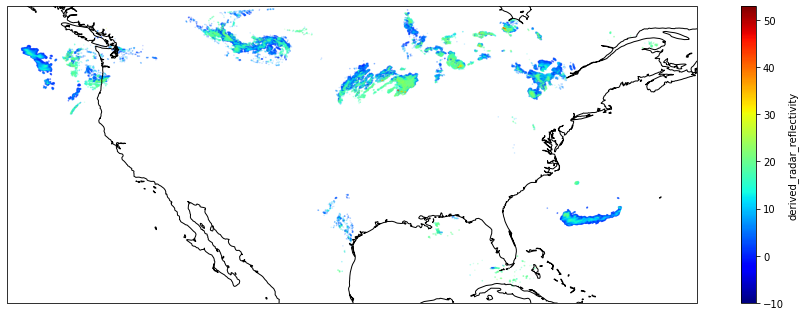

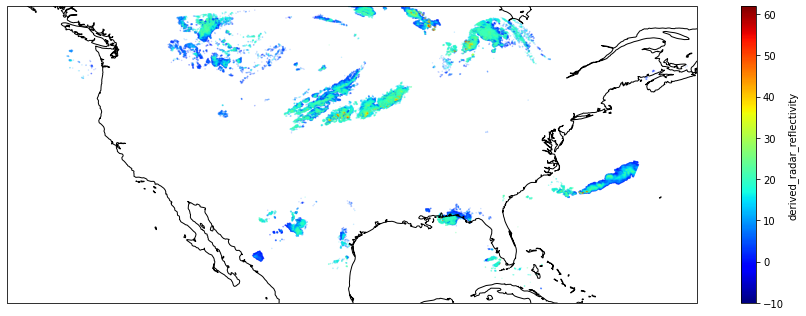

<Figure size 432x288 with 0 Axes>

In [160]:
from typing import Callable, Literal, overload, Iterator
import xarray as xr


class GribBase:
    def __init__(self, files: list[str]) -> None:
        self._file_list = files

    def __repr__(self):
        return "{0}.propertys({1})".format(
            self.__class__.__name__,
            ", ".join(attr for attr in self.__dir__() if not attr.startswith("_")),
        )

    def iterfiles(self) -> Iterator[str]:
        yield from self._file_list


def filter_by_level(level: str):
    """decorator"""

    lat_lon_vt = {"latitude", "longitude", "valid_time"}

    def generator(grib: GribBase, **kwargs):
        for file in grib.iterfiles():
            with xr.open_dataset(
                file,
                engine="cfgrib",
                **kwargs,
            ) as ds:
                if lat_lon_vt.issubset(ds.coords):
                    yield ds.drop_vars(coord for coord in ds.coords if coord not in lat_lon_vt)

    def func_wrapper(func: Callable[["GribBase"], dict[str, str]]):
        """the func() is the returned value from the function"""

        @overload
        def key_filter(
            self: "GribBase",
            name: str = ...,
            stepType: Literal["max", "instant"] = ...,
            shortName: str = ...,
            standard_name: str = ...,
            **kwargs: str,
        ) -> xr.Dataset:
            ...

        def key_filter(grib: "GribBase", **kwargs: str) -> xr.Dataset:
            """the wrapped func"""

            default_return = func(grib)

            if not default_return:
                filter_by_keys = {"typeOfLevel": level} | kwargs
            else:
                filter_by_keys = {"typeOfLevel": level} | default_return | kwargs

            objs = generator(
                grib,
                filter_by_keys=filter_by_keys,
                chunks={},
            )
            return xr.concat(objs, dim="valid_time")

        return key_filter

    return func_wrapper


class ByLevel(GribBase, DocStrings):
    @property
    def type_of_level(self):
        """list of typeOfLevel arguments that should be passed when opening a dataset"""
        return LEVEL_TYPES

    @filter_by_level("atmosphere")
    def atmosphere(self):
        """returns all attributes at with the shared `atmosphere` level"""

    @filter_by_level("isothermal")
    def isothermal(self):
        """returns all attributes at with the shared `isothermal` level"""
        return {"stepType": "instant"}

    @filter_by_level("hybrid")
    def hybrid(self):
        """returns all attributes at with the shared `hybrid` level"""

    @filter_by_level("heightAboveGroundLayer")
    def height_above_ground_layer(self):
        """returns all attributes at with the shared `heightAboveGroundLayer` level"""


class HRRR(ByLevel):
    def geopotential_height(self, level="isothermal") -> xr.Dataset:
        match level:
            case "isothermal":
                return super().isothermal(name="Geopotential Height", stepType="instant")
            case "hybrid":
                return super().hybrid(name="Geopotential Height")

    def pressure(self) -> xr.Dataset:
        return super().hybrid(name="Pressure")

    def unknown(self) -> xr.Dataset:
        return super().hybrid(name="unknown")

    def mixing_ratio(self, kind: Literal["rain", "snow", "cloud"] = "rain") -> xr.Dataset:
        return super().hybrid(name=f"{kind.title()} mixing ratio")

    def graupel(self) -> xr.Dataset:
        return super().hybrid(name="Graupel (snow pellets)")

    def particulate_matter(self, kind: Literal["fine", "coarse"] = "fine") -> xr.Dataset:
        return super().hybrid(name=f"Particulate matter ({kind})")

    def fraction_of_cloud_cover(self) -> xr.Dataset:
        return super().hybrid(name="Fraction of cloud cover")

    def temperature(self) -> xr.Dataset:
        return super().hybrid(name="Temperature")

    def specific_humidity(self) -> xr.Dataset:
        return super().hybrid(name="Specific humidity")

    def u_component_of_wind(self) -> xr.Dataset:
        return super().hybrid(name="U component of wind")

    def v_component_of_wind(self):
        return super().hybrid(name="V component of wind")

    def vertical_velocity(self) -> xr.Dataset:
        return super().hybrid(name="Vertical velocity")

    def turbulent_kinetic_energy(self) -> xr.Dataset:
        return super().hybrid(name="Turbulent kinetic energy")

    def derived_radar_reflectivity(self, step_type: Literal["max", "instant"] = "instant") -> xr.Dataset:
        return super().isothermal(name="Derived radar reflectivity", stepType=step_type)


import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np


def open_gribs(files: list[str]) -> HRRR:
    return HRRR(files if isinstance(files, list) else [files])


def format_var_names(ds: xr.Dataset):
    for v in ds.data_vars.values():
        print(
            f"""\
name : {v.attrs["GRIB_name"]}
units : {v.attrs["GRIB_units"]}
shortName : {v.attrs["GRIB_shortName"]}
"""
        )
        for a, b in v.coords.items():
            print(f"{a} : {b.dtype}")


def scatter_plot(ds: xr.Dataset, parameter: str, **kwargs):
    columns = {
        v.attrs["GRIB_shortName"]: v.attrs["long_name"].lower().replace(" ", "_") for v in ds.data_vars.values()
    }
    for vt, df in ds.to_dataframe().rename(columns=columns).groupby("valid_time"):
        plt.rcParams["axes.grid"] = True
        ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
        plt.figure(vt.value)

        ax.coastlines("50m")

        ax.set_extent(
            [
                *df["longitude"].agg(["min", "max"]),
                *df["latitude"].agg(["min", "max"]),
            ],
            ccrs.PlateCarree(),
        )

        df.plot(
            kind="scatter",
            y="latitude",
            x="longitude",
            c=parameter,
            ax=ax,
            alpha=np.where(df[parameter] > 0, 0.2, 0),
            cmap=plt.get_cmap("jet"),
            s=0.25,
            figsize=(16, 12),
            **kwargs,
        )


# hrrr.derived_radar_reflectivity()
if __name__ == "__main__":
    hrrr = open_gribs(glob("data/hrrr/*.grib2")[:2])
    hrrr.derived_radar_reflectivity().pipe(scatter_plot, parameter="derived_radar_reflectivity")

In [ ]:
name : Cloud mixing ratio
units : kg kg**-1
shortName : clwmr

latitude : float64
longitude : float64
valid_time : datetime64[ns]


name : Rain mixing ratio
units : kg kg**-1
shortName : rwmr

latitude : float64
longitude : float64
valid_time : datetime64[ns]


name : Snow mixing ratio
units : kg kg**-1
shortName : snmr

latitude : float64
longitude : float64
valid_time : datetime64[ns]

In [67]:
class Base(ABC):
    @abstractmethod
    def one(self, **kwargs):
        """hello"""


class A:
    ...


class C(A, Base):
    def one(self):
        return 1


c = C()
c.one()

1

In [207]:
from functools import wraps


def a_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        """A wrapper function"""

        # Extend some capabilities of func
        func()

    return wrapper


@a_decorator
def first_function():
    """This is docstring for first function"""
    print("first function")


@a_decorator
def second_function(a):
    """This is docstring for second function"""
    print("second function")


print(first_function.__name__)
print(first_function.__doc__)
print(second_function.__name__)
print(second_function.__doc__)

first_function
This is docstring for first function
second_function
This is docstring for second function


In [182]:
hrrr.hybrid()

<xarray.Dataset>
Dimensions:     (y: 1059, x: 1799, valid_time: 2, hybrid: 50)
Coordinates:
    latitude    (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude   (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.1
  * valid_time  (valid_time) datetime64[ns] 2022-06-15T16:00:00 2022-06-15T05...
Dimensions without coordinates: y, x, hybrid
Data variables: (12/16)
    pres        (valid_time, hybrid, y, x) float32 dask.array<chunksize=(1, 50, 1059, 1799), meta=np.ndarray>
    clwmr       (valid_time, hybrid, y, x) float32 dask.array<chunksize=(1, 50, 1059, 1799), meta=np.ndarray>
    unknown     (valid_time, hybrid, y, x) float32 dask.array<chunksize=(1, 50, 1059, 1799), meta=np.ndarray>
    rwmr        (valid_time, hybrid, y, x) float32 dask.array<chunksize=(1, 50, 1059, 1799), meta=np.ndarray>
    snmr        (valid_time, hybrid, y, x) float32 dask.array<chunksize=(1, 50, 1059, 1799), meta=np.ndarray>
    grle        (valid_time, hybrid, y, x) float32 dask.array<chunksize=(1, 50, 1059, 1799), meta=np.ndarray>
    ...          ...
    t           (valid_time, hybrid, y, x) float32 dask.array<chunksize=(1, 50, 1059, 1799), meta=np.ndarray>
    q           (valid_time, hybrid, y, x) float32 dask.array<chunksize=(1, 50, 1059, 1799), meta=np.ndarray>
    u           (valid_time, hybrid, y, x) float32 dask.array<chunksize=(1, 50, 1059, 1799), meta=np.ndarray>
    v           (valid_time, hybrid, y, x) float32 dask.array<chunksize=(1, 50, 1059, 1799), meta=np.ndarray>
    w           (valid_time, hybrid, y, x) float32 dask.array<chunksize=(1, 50, 1059, 1799), meta=np.ndarray>
    tke         (valid_time, hybrid, y, x) float32 dask.array<chunksize=(1, 50, 1059, 1799), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-06-26T17:28 GRIB to CDM+CF via cfgrib-0.9.1...

In [194]:
def format_var_names(ds:xr.Dataset):
    return "\n".join(
        f"""\
name : {v.attrs["GRIB_name"]}
units : {v.attrs["GRIB_units"]}
shortName : {v.attrs["GRIB_shortName"]}
"""
        for v in ds.data_vars.values()
    )

name : Pressure
units : Pa
shortName : pres

name : Cloud mixing ratio
units : kg kg**-1
shortName : clwmr

name : unknown
units : unknown
shortName : unknown

name : Rain mixing ratio
units : kg kg**-1
shortName : rwmr

name : Snow mixing ratio
units : kg kg**-1
shortName : snmr

name : Graupel (snow pellets)
units : kg kg**-1
shortName : grle

name : Particulate matter (fine)
units : (10**-6 g) m**-3
shortName : pmtf

name : Particulate matter (coarse)
units : (10**-6 g) m**-3
shortName : pmtc

name : Fraction of cloud cover
units : (0 - 1)
shortName : cc

name : Geopotential Height
units : gpm
shortName : gh

name : Temperature
units : K
shortName : t

name : Specific humidity
units : kg kg**-1
shortName : q

name : U component of wind
units : m s**-1
shortName : u

name : V component of wind
units : m s**-1
shortName : v

name : Vertical velocity
units : Pa s**-1
shortName : w

name : Turbulent kinetic energy
units : J kg**-1
shortName : tke



In [43]:
hrrr.isothermal(derp="yerp")

{}


DatasetBuildError: multiple values for unique key, try re-open the file with one of:
    filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isothermal'}
    filter_by_keys={'stepType': 'max', 'typeOfLevel': 'isothermal'}

In [17]:
hrrr.isothermal

<xarray.Dataset>
Dimensions:     (y: 1059, x: 1799, valid_time: 2)
Coordinates:
    latitude    (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude   (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.1
  * valid_time  (valid_time) datetime64[ns] 2022-06-15T16:00:00 2022-06-15T05...
Dimensions without coordinates: y, x
Data variables:
    refd        (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-06-26T14:48 GRIB to CDM+CF via cfgrib-0.9.1...

<GeoAxesSubplot:xlabel='longitude', ylabel='latitude'>

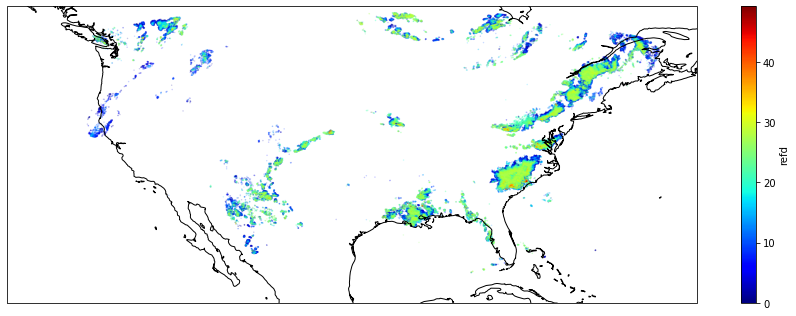

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

idx: slice = pd.IndexSlice

plt.rcParams["axes.grid"] = True

ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())

valid_times = df.index.unique("valid_time").sort_values()
ax.coastlines("50m")

ax.set_extent(
    [
        *df["longitude"].agg(["min", "max"]),
        *df["latitude"].agg(["min", "max"]),
    ],
    ccrs.PlateCarree(),
)
df0 = df.loc[idx[:, :, valid_times[0]], :]

df0.plot(
    kind="scatter",
    y="latitude",
    x="longitude",
    c="refd",
    ax=ax,
    alpha=np.where(df0["refd"] > 0, 0.2, 0),
    cmap=plt.get_cmap("jet"),
    s=0.25,
    figsize=(16, 12),
)

In [7]:
import pandas as pd

# in most cases setting the valid_time , latitude , longitude makes the most sense
def normalize_index(df: pd.DataFrame) -> pd.DataFrame:
    df["valid_time"] = df.time + df.step
    return df.drop(["time", "step"], axis=1).set_index(["valid_time", "latitude", "longitude"])


# using the pipe method keeps
ds.to_dataframe().pipe(normalize_index)

NameError: name 'ds' is not defined

In [ ]:
df = ds.to_dataframe()
df["longitude"] = (df["longitude"] + 180) % 360 - 180
# df.plot()

<GeoAxesSubplot:xlabel='longitude', ylabel='latitude'>

/opt/venv/lib/python3.10/site-packages/Cartopy-0.20.2-py3.10-linux-x86_64.egg/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


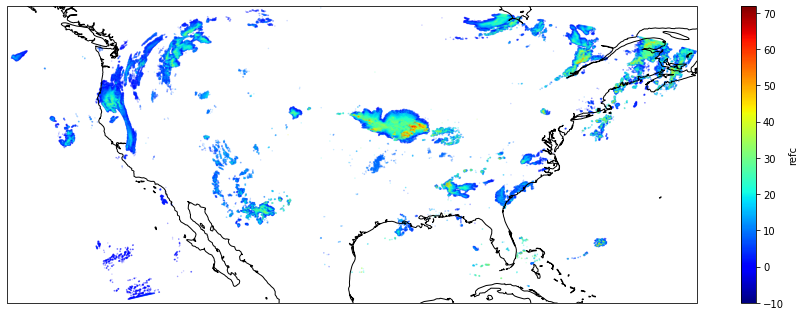

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np


plt.rcParams["axes.grid"] = True

ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())

ax.coastlines("50m")

ax.set_extent(
    [
        *df["longitude"].agg(["min", "max"]),
        *df["latitude"].agg(["min", "max"]),
    ],
    ccrs.PlateCarree(),
)

df.plot(
    kind="scatter",
    y="latitude",
    x="longitude",
    c="refc",
    ax=ax,
    alpha=np.where(df["refc"] > 0, 0.2, 0),
    cmap=plt.get_cmap("jet"),
    s=0.25,
    figsize=(16, 12),
)

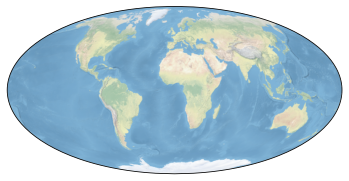

In [ ]:
ax = plt.axes(projection=ccrs.Mollweide())
ax.stock_img()
plt.show()

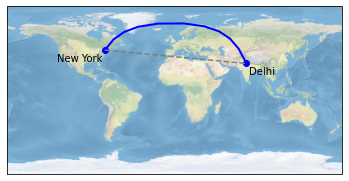

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

ny_lon, ny_lat = -75, 43
delhi_lon, delhi_lat = 77.23, 28.61

plt.plot(
    [ny_lon, delhi_lon],
    [ny_lat, delhi_lat],
    color="blue",
    linewidth=2,
    marker="o",
    transform=ccrs.Geodetic(),
)

plt.plot(
    [ny_lon, delhi_lon],
    [ny_lat, delhi_lat],
    color="gray",
    linestyle="--",
    transform=ccrs.PlateCarree(),
)

plt.text(ny_lon - 3, ny_lat - 12, "New York", horizontalalignment="right", transform=ccrs.Geodetic())

plt.text(delhi_lon + 3, delhi_lat - 12, "Delhi", horizontalalignment="left", transform=ccrs.Geodetic())

plt.show()